---
title: Real-time benchmarking for qubit selection
description: Run real-time characterization experiments and update backend properties to improve qubit selection when mapping a circuit to the physical qubits on a QPU.
---

{/* cspell:ignore sharex */}

# Real-Time Benchmarking for Qubit Selection

Usage estimate: 31min 30s on a Heron R2 processor (NOTE: This is an estimate only. Your runtime might vary.)

### Background and Tutorial Overview

This tutorial shows how to run real-time characterization experiments and update backend properties to improve qubit selection when mapping a circuit to the physical qubits on a quantum processing unit (QPU).

The main goal is to demonstrate the benefits of running real-time characterization experiments before executing a quantum circuit. Specifically, we explain why selecting the best qubit layout matters and how the quality of a layout can directly influence circuit fidelity.

A qubit layout refers to the specific set of physical qubits on which a quantum circuit is mapped. All operations in the circuit are executed only on these qubits, meaning that the hardware performance of the chosen layout has a direct impact on the circuit’s overall fidelity.

You will learn how to:

- Perform basic characterization experiments in Qiskit to determine the key properties of a QPU.

- Update QPU error properties with real-time data and use them to transpile circuits, enabling the selection of the best-performing qubit layouts before execution on actual hardware.

To highlight the benefits of real-time QPU characterization, we will establish a correlation between predicted and measured hardware performance. This will be done by transpiling and running the same circuit across several randomly selected layouts and comparing their outcomes. As a case study, we focus on a modified [Local Unitary Cluster Jastrow (LUCJ) circuit](https://qiskit-community.github.io/ffsim/dev/explanations/lucj.html), which is commonly used as an ansatz to estimate the ground-state energy of correlated electronic systems.

#### Why does this matter?

A quantum processor’s properties can drift faster than the interval between reported QPU updates. One common cause is [two-level-systems (TLS) interactions](https://www.nature.com/articles/s41534-022-00643-y), which fluctuate on short timescales and can temporarily degrade qubit performance. When this happens, the qubit selection routines in Qiskit’s transpile stage may rely on outdated data, leading to suboptimal circuit mappings. Running real-time characterization experiments before execution helps capture the current hardware state and update backend properties, improving layout reliability and circuit performance.

### Requirements

Before starting this tutorial, be sure you have the following installed:

- Qiskit SDK v2.0 or later, with visualization support ( `pip install 'qiskit[visualization]' `)
- Qiskit Runtime v0.42 or later ( `pip install qiskit-ibm-runtime `)
- Qiskit Experiments v0.12 or later ( `pip install qiskit-experiments `)
- Python-based Simulations of Chemistry Framework v2.1 or later (` pip install pyscf `)
- ffsim v0.0.58 or later (` pip install ffsim` )
- Qiskit Device Benchmarking v0.1 or later

    (`git clone git@github.com:qiskit-community/qiskit-device-benchmarking.git`

    `cd qiskit-device-benchmarking`

    `pip install .`)

### Setup

In [27]:
import pyscf
import pyscf.cc
import pyscf.mcscf
from pyscf.data.elements import chemcore

import rustworkx as rx
from rustworkx import NoEdgeBetweenNodes, PyGraph
from typing import List, Tuple
import numpy as np
import pandas as pd
import ffsim
from datetime import datetime, timedelta
import random
from collections import Counter
import matplotlib.pyplot as plt
import re

from qiskit import QuantumCircuit, QuantumRegister
from qiskit import QiskitError
from qiskit.transpiler import CouplingMap
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
from qiskit.transpiler.passmanager import PassManager
from qiskit.transpiler.passes import RemoveIdentityEquivalent
from qiskit.providers import BackendV2
from qiskit.result import marginal_counts as mcts

from qiskit_experiments.framework import BatchExperiment, ParallelExperiment
from qiskit_experiments.library import StandardRB
from qiskit_experiments.library.randomized_benchmarking import LayerFidelity

import qiskit_device_benchmarking.utilities.graph_utils as gu
import qiskit_device_benchmarking.utilities.layer_fidelity_utils as lfu
import qiskit_device_benchmarking.utilities.characterization_utils as cu

from qiskit_ibm_runtime import QiskitRuntimeService, Session
from qiskit_ibm_runtime import SamplerV2 as Sampler
from qiskit_ibm_runtime.models import BackendProperties
from qiskit_ibm_runtime.transpiler.passes.basis.fold_rzz_angle import (
    FoldRzzAngle,
)

## Select a backend

Using the Qiskit IBM Runtime service, we select a QPU to run on.

There are some options we can define when choosing a backend, such as enabling fractional gates. Fractional gates are parameterized quantum gates that enable direct execution of arbitrary-angle rotations (within specific bounds), eliminating the need to decompose them into multiple basis gates. We are using them in this tutorial because they can significantly reduce both the depth and duration of quantum circuits, which helps with the total QPU time of the characetrization experiments described below, but note that they are not required to run characterization experiments in general. For more information on fractional gates, feel free to check out [this tutorial](https://quantum.cloud.ibm.com/docs/en/tutorials/fractional-gates).

In [ ]:
service = QiskitRuntimeService()
backend = service.least_busy(
    operational=True, simulator=False, use_fractional_gates=True
)
device = backend.name
print(device)

management.get:WARNING:2026-02-26 20:47:14,405: Loading default saved account


ibm_fez


## Defining real-time characterization experiments

Below is a list of common characterization experiments used to describe the properties of a QPU (please refer to the [qiskit-experiments](https://qiskit-community.github.io/qiskit-experiments/index.html) package for more details). These primarily target errors in single- and two-qubit control operations. While experiments such as T₁ and T₂ characterization are also common, we exclude them here to save QPU time. Moreover, the experiments shown below already capture some of their effects—for example, a qubit with a short T₁ relaxation time often exhibits higher control errors when the gate time is comparable to the relaxation time.

### Readout

In a a state preparation and measurement (SPAM) experiment, also known as a readout experiment, qubits are initialized in a known state—either ∣0⟩ or ∣1⟩—and then measured. In real quantum devices, hardware imperfections can cause deviations in both the preparation and measurement processes.

To estimate these errors, we run two simple experiments for each qubit:

- Ground-State Test: We measure the qubit without applying any gate. Ideally, it should be in the ∣0⟩ state. Any measurement of ∣1⟩ indicates an error.

- Excited-State Test: We apply an X gate to flip the qubit to ∣1⟩, then measure it. If we instead get ∣0⟩, this also indicates an error.

### Single qubit Randomized Benchmarking (1Q errors)

[Randomized Benchmarking (RB)](https://qiskit-community.github.io/qiskit-experiments/manuals/verification/randomized_benchmarking.html) is a widely used technique to estimate gate error rates in quantum processors. In this case below we focus on 1Q errors. In randomized benchmarking, sequences of random Clifford gates are generated such that, in the absence of errors, they would ideally return qubits to their initial state. After execution, the probability of shots that returns to the initial state is used to estimate the Error Per Clifford (EPC).

### Layer Fidelity (2Q errors)

IBM Quantum introduced [Layer Fidelity](https://qiskit-community.github.io/qiskit-experiments/stubs/qiskit_experiments.library.randomized_benchmarking.LayerFidelity.html) — a new metric that evaluates a processor’s ability to run layered circuits across the entire device. One can extract 2Q errors from this experiment. Layer Fidelity extends randomized benchmarking by aggregating data over many layers of simultaneous two-qubit (2Q) gates, providing valuable insight into crosstalk and 2Q gate length limitations that often bottleneck large-scale quantum algorithms.

To capture these system-wide effects, Layer Fidelity is run on all edges (i.e., 2Q gates) in a device. This is implemented through the [Layer Fidelity Grid method](https://github.com/qiskit-community/qiskit-device-benchmarking/blob/main/notebooks/layer_fidelity_placement.ipynb), which divides the QPU connectivity graph into two sets of 'qubit chains' that together capture all edges and then runs Layer Fidelity on each of them:

- One set runs vertically across the device,

- The other runs horizontally.

### QPU properties over time

Looking at the reported QPU properties over time (we'll consider a single week below), we see how these can fluctuate on a scale of a single day. Small fluctuations can happen even in shorter timescales, mostly due to unexpected environment interactions. In this scenario, the reported properties will not accurately capture the current status of the QPU. Moreover, if a job is transpiled locally (using current reported properties) and submitted but executed only at a later time (minutes or days), it may run the risk of having used outdated properties for qubit selection in the transpilation step. This highlights the importance of having updated information about the QPU at execution time.

In [29]:
# Get two qubit gate
if "ecr" in backend.configuration().basis_gates:
    twoq_gate = "ecr"
elif "cz" in backend.configuration().basis_gates:
    twoq_gate = "cz"
else:
    twoq_gate = "cx"
    
# Let's retrieve the properties over a certain time range
days = 7
errors_list = []
for day_idx in range(0, days):
    calibrations_time = datetime.now() - timedelta(days=day_idx)
    targer_hist = backend.target_history(datetime=calibrations_time)

    t1_dict, t2_dict = {}, {}
    for qubit in range(targer_hist.num_qubits):
        t1_dict[qubit] = targer_hist.qubit_properties[qubit].t1
        t2_dict[qubit] = targer_hist.qubit_properties[qubit].t2

    errors_dict = {
        "1q": targer_hist["sx"],
        "2q": targer_hist[twoq_gate],
        "spam": targer_hist["measure"],
    }

    errors_list.append(errors_dict)

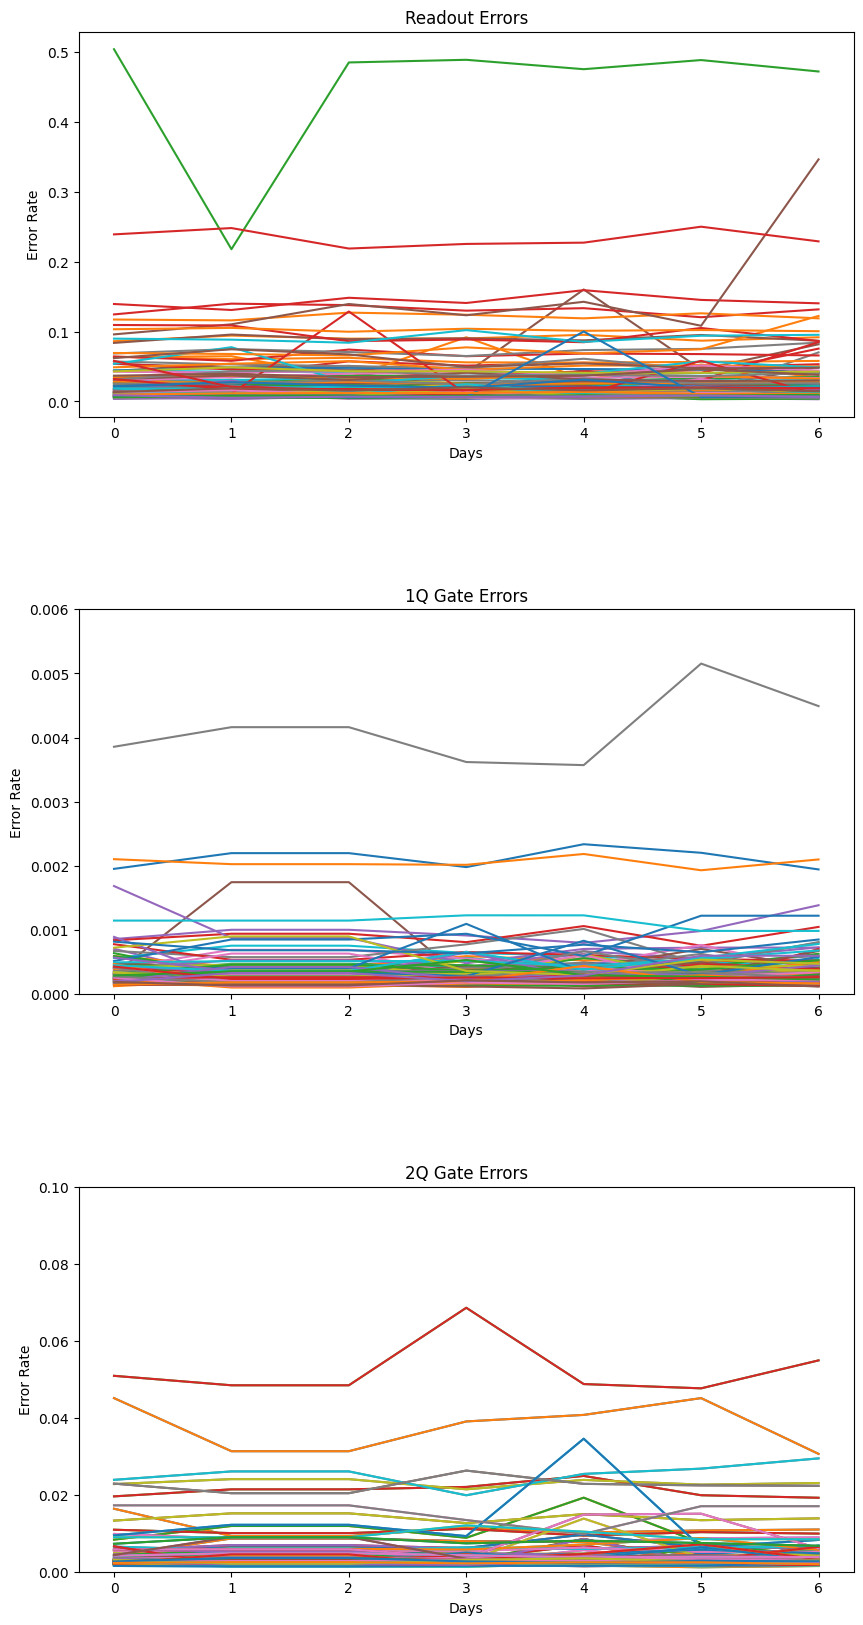

In [32]:
# Let's plot these properties over time
fig, axs = plt.subplots(3, 1, figsize=(10, 20), sharex=False)

# Plot readout values
for qubit in range(targer_hist.num_qubits):
    spams = []
    for errors_dict in errors_list:
        spam_dict = errors_dict["spam"]
        spams.append(spam_dict[tuple([qubit])].error)

    axs[0].plot(spams)

axs[0].set_title("Readout Errors")
axs[0].set_ylabel("Error Rate")
axs[0].set_xlabel("Days")

# Plot 1Q Gate Errors
for qubit in range(targer_hist.num_qubits):
    oneq_gates = []
    for errors_dict in errors_list:
        oneq_gate_dict = errors_dict["1q"]
        oneq_gates.append(oneq_gate_dict[tuple([qubit])].error)

    axs[1].plot(oneq_gates)

axs[1].set_title("1Q Gate Errors")
axs[1].set_ylabel("Error Rate")
axs[1].set_xlabel("Days")
axs[1].set_ylim([0, 0.006])

# Plot 2Q Gate Errors
edges = list(backend.target[twoq_gate].keys())
for pair in edges:
    twoq_gates = []
    for errors_dict in errors_list:
        twoq_gate_dict = errors_dict["2q"]
        twoq_gates.append(twoq_gate_dict[pair].error)

    axs[2].plot(twoq_gates)

axs[2].set_title("2Q Gate Errors")
axs[2].set_ylabel("Error Rate")
axs[2].set_xlabel("Days")
axs[2].set_ylim([0, 0.1])

plt.subplots_adjust(hspace=0.5)
plt.show()

### When in a workflow should characterization experiments be run?

Characterization experiments should be run before transpilation. Once the characterization experiments are completed, their results can be used to update the QPU error properties. These updates directly affect the transpilation step as they provide real-time data on hardware perfromamce. In practice, it is best to run all jobs as close in time as possible, which can be achieved by executing them within a single session.

The typical workflow is as follows:

- Run characterization experiments.
- Update QPU properties.
- Transpile the circuit using the updated backend.
- Execute the circuit on hardware.

Note: Before running the full workflow in a single session, ensure that each part of your code executes successfully on its own.

## Step 1: Map classical inputs to a quantum problem

Let us put this to practice. We'll define a circuit of interest, in our case a modified LUCJ circuit, and transpile the circuit to randomly selected layouts. We'll then run QPU characterization experiments, along with the modified LUCJ circuit on the randomly selected layouts, and compare the correlation between QPU error properties and layout performance.

In Step 1, we begin by defining our circuit, a modified version of a LUCJ circuit. We'll do this for a N₂ molecule using the 6-31G basis set, which is a common choice in quantum chemistry for balancing accuracy and computational cost. From this specification, we can obtain the molecular properties needed for our circuit.

We then construct a modified LUCJ circuit, which is designed to simplify validation of results. This circuit:
- Starts from the Hartree–Fock state.
- Applies the LUCJ operator together with its inverse.

Because of the mirrored structure of the circuit, the final output state is still the Hartree-Fock state, allowing direct validation of measurement outcomes. To avoid excessive circuit depth, we remove the two adjacent orbital rotations in the middle of the circuit, and replace them with a barrier to prevent the transpiler from performing further gate cancellations. The resulting circuit has a similar structure to a single layer of a typical LUCJ circuit.

In [33]:
# Specify molecule properties
open_shell = False
spin_sq = 0

# Build N2 molecule
mol = pyscf.gto.Mole()
mol.build(
    atom=[["N", (0, 0, 0)], ["N", (1.0, 0, 0)]],
    basis="6-31g",
    symmetry="Dooh",
)

# Get the active space
ncore = chemcore(mol)
naorb = mol.nao_nr() - ncore
active_space = [p for p in range(ncore, mol.nao_nr())]

# Get molecular integrals
scf = pyscf.scf.RHF(mol).run()
num_orbitals = len(active_space)
n_electrons = int(sum(scf.mo_occ[active_space]))
num_elec_a = (n_electrons + mol.spin) // 2
num_elec_b = (n_electrons - mol.spin) // 2
cas = pyscf.mcscf.CASCI(scf, num_orbitals, (num_elec_a, num_elec_b))
mo = cas.sort_mo(active_space, base=0)
hcore, nuclear_repulsion_energy = cas.get_h1cas(mo)
eri = pyscf.ao2mo.restore(1, cas.get_h2cas(mo), num_orbitals)

converged SCF energy = -108.835236570774


Before constructing the modified LUCJ ansatz circuit, we first perform a CCSD calculation. The [t1​ and t2 amplitudes](https://en.wikipedia.org/wiki/Coupled_cluster#Cluster_operator) from this calculation will be used to initialize the parameters of the ansatz.

We then use [ffsim](https://github.com/qiskit-community/ffsim) to create the circuit. Since our molecule has a closed-shell Hartree-Fock state, we use the spin-balanced variant of the UCJ ansatz, UCJOpSpinBalanced. We pass interaction pairs appropriate for a heavy-hex lattice qubit topology (see the background section on the LUCJ ansatz).

In [34]:
# Get CCSD t2 amplitudes for initializing the ansatz
ccsd = pyscf.cc.CCSD(
    scf, frozen=[i for i in range(mol.nao_nr()) if i not in active_space]
).run()
t1 = ccsd.t1
t2 = ccsd.t2

# Prepare UCJ operator
n_reps = 1
alpha_alpha_indices = [(p, p + 1) for p in range(num_orbitals - 1)]
alpha_beta_indices = [(p, p) for p in range(0, num_orbitals, 4)]
nelec = (num_elec_a, num_elec_b)

ucj_op = ffsim.UCJOpSpinBalanced.from_t_amplitudes(
    t2=t2,
    t1=t1,
    n_reps=n_reps,
    interaction_pairs=(alpha_alpha_indices, alpha_beta_indices),
)
orbital_rotation = ucj_op.orbital_rotations[0]
diag_coulomb_mat_aa, diag_coulomb_mat_ab = ucj_op.diag_coulomb_mats[0]

# Create an empty quantum circuit
qubits = QuantumRegister(2 * num_orbitals, name="q")
circuit = QuantumCircuit(qubits)

# Prepare Hartree-Fock state as the reference state and append it to the quantum circuit
circuit.append(ffsim.qiskit.PrepareHartreeFockJW(num_orbitals, nelec), qubits)

# Apply the UCJ operator to the reference state
circuit.append(
    ffsim.qiskit.OrbitalRotationJW(ucj_op.norb, orbital_rotation.T.conj()),
    qubits,
)
circuit.append(
    ffsim.qiskit.DiagCoulombEvolutionJW(
        ucj_op.norb,
        (diag_coulomb_mat_aa, diag_coulomb_mat_ab, diag_coulomb_mat_aa),
        -1.0,
    ),
    qubits,
)

# Add a barrier for transpilation
circuit.barrier()

# Apply the inverse UCJ operator
circuit.append(
    ffsim.qiskit.DiagCoulombEvolutionJW(
        ucj_op.norb,
        (diag_coulomb_mat_aa, diag_coulomb_mat_ab, diag_coulomb_mat_aa),
        1.0,
    ),
    qubits,
)
circuit.append(
    ffsim.qiskit.OrbitalRotationJW(ucj_op.norb, orbital_rotation), qubits
)

# Measure qubits
circuit.measure_all()

E(CCSD) = -109.0398256929733  E_corr = -0.20458912219883


In [35]:
# Let's draw the circuit
circuit.draw(fold=-1)

┌───────────────────┐┌──────────────┐┌───────────────────┐ ░ ┌───────────────────┐┌──────────────┐ ░ ┌─┐                                                                                             
    q_0: ┤0                  ├┤0             ├┤0                  ├─░─┤0                  ├┤0             ├─░─┤M├─────────────────────────────────────────────────────────────────────────────────────────────
         │                   ││              ││                   │ ░ │                   ││              │ ░ └╥┘┌─┐                                                                                          
    q_1: ┤1                  ├┤1             ├┤1                  ├─░─┤1                  ├┤1             ├─░──╫─┤M├──────────────────────────────────────────────────────────────────────────────────────────
         │                   ││              ││                   │ ░ │                   ││              │ ░  ║ └╥┘┌─┐                                                                                       
    q_2: ┤2                  ├┤2             ├┤2                  ├─░─┤2                  ├┤2             ├─░──╫──╫─┤M├───────────────────────────────────────────────────────────────────────────────────────
         │                   ││              ││                   │ ░ │                   ││              │ ░  ║  ║ └╥┘┌─┐                                                                                    
    q_3: ┤3                  ├┤3             ├┤3                  ├─░─┤3                  ├┤3             ├─░──╫──╫──╫─┤M├────────────────────────────────────────────────────────────────────────────────────
         │                   ││              ││                   │ ░ │                   ││              │ ░  ║  ║  ║ └╥┘┌─┐                                                                                 
    q_4: ┤4                  ├┤4             ├┤4                  ├─░─┤4                  ├┤4             ├─░──╫──╫──╫──╫─┤M├─────────────────────────────────────────────────────────────────────────────────
         │                   ││              ││                   │ ░ │                   ││              │ ░  ║  ║  ║  ║ └╥┘┌─┐                                                                              
    q_5: ┤5                  ├┤5             ├┤5                  ├─░─┤5                  ├┤5             ├─░──╫──╫──╫──╫──╫─┤M├──────────────────────────────────────────────────────────────────────────────
         │                   ││              ││                   │ ░ │                   ││              │ ░  ║  ║  ║  ║  ║ └╥┘┌─┐                                                                           
    q_6: ┤6                  ├┤6             ├┤6                  ├─░─┤6                  ├┤6             ├─░──╫──╫──╫──╫──╫──╫─┤M├───────────────────────────────────────────────────────────────────────────
         │                   ││              ││                   │ ░ │                   ││              │ ░  ║  ║  ║  ║  ║  ║ └╥┘┌─┐                                                                        
    q_7: ┤7                  ├┤7             ├┤7                  ├─░─┤7                  ├┤7             ├─░──╫──╫──╫──╫──╫──╫──╫─┤M├────────────────────────────────────────────────────────────────────────
         │                   ││              ││                   │ ░ │                   ││              │ ░  ║  ║  ║  ║  ║  ║  ║ └╥┘┌─┐                                                                     
    q_8: ┤8                  ├┤8             ├┤8                  ├─░─┤8                  ├┤8             ├─░──╫──╫──╫──╫──╫──╫──╫──╫─┤M├─────────────────────────────────────────────────────────────────────
         │                   ││              ││                   │ ░ │                   ││              │ ░  ║  ║  ║  ║  ║  ║  ║  ║ └╥┘┌─┐                                                                  
    q_9: ┤9                  ├┤9             ├┤9                  ├─░─┤9    

## Step 2: Optimize problem for quantum hardware execution

In this step, we transpile the modified LUCJ circuit to match the connectivity of the target quantum processor.

- First, we identify all possible qubit layouts on the device that follow the “zig-zag” pattern described in the [Sample-based quantum diagonalization of a chemistry Hamiltonian tutorial](https://quantum.cloud.ibm.com/docs/en/tutorials/sample-based-quantum-diagonalization) (see the picture below). This layout is particularly well-suited for the LUCJ ansatz because it reduces the number of gates required to implement the circuit. We include code to automatically search for all such layouts.

- From these, we randomly select N layouts to test. For each layout, we later incorporate the corresponding qubit and gate properties of the device, which allows us to predict performance using a cost function and compare it against the measured hardware outcomes.

- For each chosen layout, we construct a staged pass manager using Qiskit’s `generate_preset_pass_manager` function. We set the `pre_init` stage of the pass manager to `ffsim.qiskit.PRE_INIT` to enable transpiler passes that can significantly reduce gate counts by:
    - Decomposing gates into orbital rotations.
    - Merging consecutive orbital rotations.
    - Using an optimized gate decomposition if an orbital rotation is applied to a computational basis state.

- Finally, we run the pass manager on our circuit to obtain a hardware-optimized version of the modified LUCJ circuit.

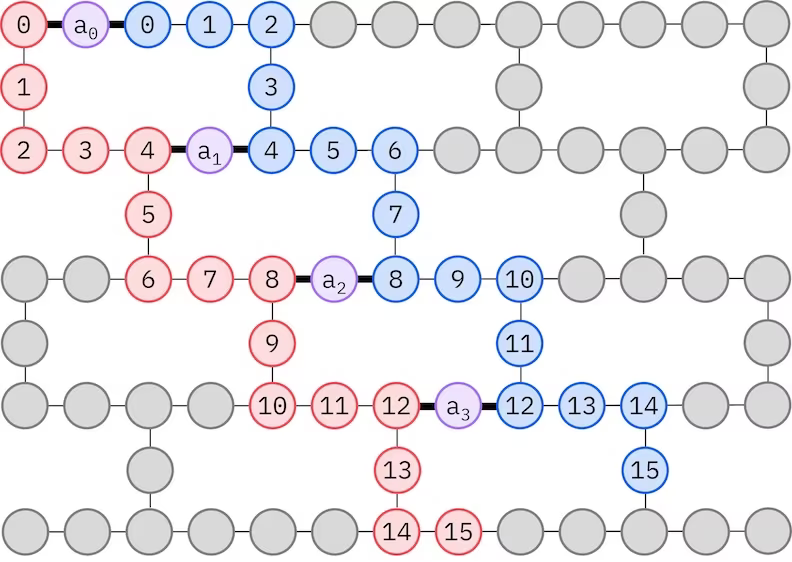

#### Randomly select a subset of zig-zag layouts

In [36]:
def create_linear_chains(num_orbitals: int) -> PyGraph:
    """
    In zig-zag layout, there are two linear chains (with connecting qubits between
    the chains). This function creates those two linear chains: a rustworkx PyGraph
    with two disconnected linear chains. Each chain contains `num_orbitals` number
    of nodes, i.e., in the final graph there are `2 * num_orbitals` number of nodes.

    Args:
        num_orbitals (int): Number orbitals or nodes in each linear chain. They are
            also known as alpha-alpha interaction qubits.

    Returns:
        A rustworkx.PyGraph with two disconnected linear chains each with `num_orbitals`
            number of nodes.
    """
    G = rx.PyGraph()

    for n in range(num_orbitals):
        G.add_node(n)

    for n in range(num_orbitals - 1):
        G.add_edge(n, n + 1, None)

    for n in range(num_orbitals, 2 * num_orbitals):
        G.add_node(n)

    for n in range(num_orbitals, 2 * num_orbitals - 1):
        G.add_edge(n, n + 1, None)

    return G


def create_lucj_zigzag_layout(
    num_orbitals: int, backend_coupling_graph: PyGraph
) -> tuple[PyGraph, int]:
    """
    This function creates the complete zigzag graph that 'can be mapped' to a IBM QPU with
    heavy-hex connectivity (the zigzag must be an isomorphic sub-graph to the QPU/backend
    coupling graph for it to be mapped).
    The zigzag pattern includes both linear chains (alpha-alpha interactions) and connecting
    qubits between the linear chains (alpha-beta interactions).

    Args:
        num_orbitals (int): Number of orbitals, i.e., number of nodes in each alpha-alpha linear chain.
        backend_coupling_graph (PyGraph): Coupling map of the backend

    Returns:
        G_new (PyGraph): The graph with IBM backend compliant zigzag pattern.
        num_alpha_beta_qubits (int): Number of connecting qubits between the linear chains
            in the zigzag pattern.
    """
    isomorphic = False
    G = create_linear_chains(num_orbitals=num_orbitals)

    num_iters = num_orbitals
    while not isomorphic:
        G_new = G.copy()
        num_alpha_beta_qubits = 0
        for n in range(num_iters):
            if n % 4 == 0:
                new_node = 2 * num_orbitals + num_alpha_beta_qubits
                G_new.add_node(new_node)
                G_new.add_edge(n, new_node, None)
                G_new.add_edge(new_node, n + num_orbitals, None)
                num_alpha_beta_qubits = num_alpha_beta_qubits + 1
        isomorphic = rx.is_subgraph_isomorphic(backend_coupling_graph, G_new)
        num_iters -= 1

    return G_new, num_alpha_beta_qubits


def _make_backend_cmap_pygraph(backend: BackendV2) -> PyGraph:
    graph = backend.coupling_map.graph
    if not graph.is_symmetric():
        graph.make_symmetric()
    backend_coupling_graph = graph.to_undirected()

    edge_list = backend_coupling_graph.edge_list()
    removed_edge = []
    for edge in edge_list:
        if set(edge) in removed_edge:
            continue
        try:
            backend_coupling_graph.remove_edge(edge[0], edge[1])
            removed_edge.append(set(edge))
        except NoEdgeBetweenNodes:
            pass

    return backend_coupling_graph


def get_zigzag_layouts(
    num_orbitals: int,
    backend: BackendV2,
) -> List[List[int]]:
    """
    Function that generates a list of zigzag pattern layouts from the
    coupling map and physical qubits of a given backend.

    Args:
        num_orbitals (int): Number of orbitals.
        backend (BackendV2): A backend.

    Returns:
        A list of device compliant layouts (list[list[int]]) with zigzag pattern
    """
    backend_coupling_graph = _make_backend_cmap_pygraph(backend)

    G, num_aplha_beta_qubits = create_lucj_zigzag_layout(
        num_orbitals=num_orbitals,
        backend_coupling_graph=backend_coupling_graph,
    )

    # Instead of generating many isomorphic layouts, we can generate only one
    # and return that as later we will be using `VF2PostLayout` to find and score
    # many isomorphic layouts.
    isomorphic_mappings = rx.vf2_mapping(
        backend_coupling_graph, G, subgraph=True
    )
    isomorphic_mappings = list(isomorphic_mappings)

    layouts = []
    for mapping in isomorphic_mappings:
        initial_layout = [None] * (2 * num_orbitals + num_aplha_beta_qubits)
        for key, value in mapping.items():
            initial_layout[value] = key
        layouts.append(initial_layout[:-num_aplha_beta_qubits])
    return layouts


def get_edges(path: List[int], backend) -> List[Tuple[int]]:
    """
    Return a list of edges from a path of qubits.

    Args:
    - path: List of nodes (qubits)
    - backend: a backend
    Returns:
    - List of edges
    """

    coupling_map = CouplingMap(backend.configuration().coupling_map)
    G = coupling_map.graph
    edges = []
    prev_node = None
    # get all prossible edges from the nodes provided
    for node in path:
        if prev_node is not None:
            # check the edge is in G and in the coupling map
            if (
                G.has_edge(prev_node, node)
                and (prev_node, node) in coupling_map
            ):
                edges.append((prev_node, node))
            elif (
                G.has_edge(node, prev_node)
                and (node, prev_node) in coupling_map
            ):
                edges.append((node, prev_node))
        prev_node = node
    return edges

In [38]:
# find all possible zig-zag layouts
all_layouts = get_zigzag_layouts(num_orbitals, backend)
print("Number of possible zig zag layouts:", len(all_layouts))

# randomly select a subset of N layouts
N = 30 if len(all_layouts) >= 30 else len(all_layouts)
subsets = random.sample(all_layouts, N)
print("Number of randomly selected layouts:", len(subsets))

Number of possible zig zag layouts: 206
Number of randomly selected layouts: 30


In [39]:
# from datetime import date
# import yaml

# # Save randomly selected layouts locally (optional)
# today = date.today()
# print('Date:', today)

# subsets_dict = {}
# for i, v in enumerate(subsets):
#     subsets_dict[i] = v

# with open(f'{today}_{device}_{num_orbitals}_subsets.yaml', 'w') as file:
#     yaml.dump(subsets_dict, file)

#### Transpile layouts

The circuit defined on Step 1 contains a series of abstractions useful to think about quantum algorithms, but not possible to run on the hardware. To be able to run on a QPU, the circuit needs to undergo a series of operations that make up the transpilation or circuit optimization step. Transpilation may involves several steps, some of these are:

- Initial mapping of the qubits in the circuit to physical qubits on the device.
- Unrolling and optimization of the instructions in the quantum circuit to the hardware-native instructions that the backend understands.
- Routing of any qubits in the circuit that interact by injecting SWAP gates (when needed) to make it compatible with the QPU's connectivity

More information about transpilation is available in our [documentation](https://quantum.cloud.ibm.com/docs/en/guides/transpile).

In [40]:
transpiled_circuits = []

for i, layout in enumerate(subsets):
    # Transpile circuit on different layouts
    pass_manager = generate_preset_pass_manager(
        optimization_level=3,
        backend=backend,
        initial_layout=layout,
        seed_transpiler=42,
    )
    # Set the pre-initialization stage of the pass manager with passes suggested by ffsim
    pass_manager.pre_init = ffsim.qiskit.PRE_INIT
    pass_manager.post_init = PassManager([RemoveIdentityEquivalent()])
    pass_manager.post_optimization = PassManager(
        [FoldRzzAngle(), RemoveIdentityEquivalent(target=backend.target)]
    )
    transpiled = pass_manager.run(circuit)
    transpiled_circuits.append(transpiled)
    print("Counts for layout", i + 1, transpiled.count_ops())

Counts for layout 1 OrderedDict([('sx', 1933), ('rz', 1870), ('cz', 786), ('x', 138), ('measure', 32), ('barrier', 2)])
Counts for layout 2 OrderedDict([('sx', 1927), ('rz', 1914), ('cz', 786), ('x', 165), ('measure', 32), ('barrier', 2)])
Counts for layout 3 OrderedDict([('sx', 1922), ('rz', 1912), ('cz', 786), ('x', 167), ('measure', 32), ('barrier', 2)])
Counts for layout 4 OrderedDict([('sx', 1923), ('rz', 1908), ('cz', 786), ('x', 166), ('measure', 32), ('barrier', 2)])
Counts for layout 5 OrderedDict([('sx', 1922), ('rz', 1911), ('cz', 786), ('x', 168), ('measure', 32), ('barrier', 2)])
Counts for layout 6 OrderedDict([('sx', 1923), ('rz', 1908), ('cz', 786), ('x', 166), ('measure', 32), ('barrier', 2)])
Counts for layout 7 OrderedDict([('sx', 1922), ('rz', 1912), ('cz', 786), ('x', 167), ('measure', 32), ('barrier', 2)])
Counts for layout 8 OrderedDict([('sx', 1927), ('rz', 1914), ('cz', 786), ('x', 165), ('measure', 32), ('barrier', 2)])
Counts for layout 9 OrderedDict([('sx', 

## Step 3: Execute using Qiskit primitives

With the circuit optimized for hardware execution, we are now ready to run it on the target device, along with the necessary characterization experiments, and collect measurement samples.

Both the characterization routines and the modified LUCJ circuit are executed within a single session to ensure they are run as close in time as possible, so that the characterization experiments capture the state of the hardware in real-time. This minimizes the effect of hardware drift and ensures that the results reflect the actual conditions under which the circuit is executed.

We also define the sampler options used for execution. These settings control parameters such as dynamical decoupling and number of shots, which may vary depending on the specific experiment being run (e.g., fewer shots for characterization routines, more for the final LUCJ circuit).

We begin by retrieving the characterization results and using them to build updated error maps for all qubits and gates in the device. These maps allow us to refresh the readout errors, as well as single-qubit and two-qubit gate errors. The updated information is stored in a separate object `backend_updated`, which can be used by the transpiler to find an optimal qubit layout.

<div class="alert alert-block alert-warning">
<b>Note:</b> Please note that in a real application, characterization experiments should be done right before transpiling your circuit of interest, so the transpiler can use this information to select the best layout to run your circuit on. In this specific case, we have commented out the transpilation block inside of the session below because we already transpiled our circuit of interest on random layouts in Step 2 (which we needed to do in order to compare the perfomance of the circuit on different regions of the device).
</div>

In [41]:
# Run circuits
with Session(backend=backend) as session:
    # Run characterization experiments
    sampler = Sampler()

    # QPU usage < 2min on a Heron R2
    experiments = ['readout', 'rb_1q', 'rb_2q']
    backend_updated = cu.characterize_backend(backend=backend, experiments=experiments)

    # # Transpile circuit using updated QPU properties to find the best qubit layout
    # pass_manager = generate_preset_pass_manager(optimization_level=3, backend=backend_updated)
    # pass_manager.pre_init = ffsim.qiskit.PRE_INIT
    # pass_manager.post_init = PassManager([RemoveIdentityEquivalent()])
    # pass_manager.post_optimization = PassManager(
    #     [
    #         FoldRzzAngle(), RemoveIdentityEquivalent(target=backend.target)
    #     ]
    # )
    # transpiled_circuits = pass_manager.run(circuit) # for some circuit of interest

    # Run your circuit (in this case the modified LUCJ circuit) and define sampler options to turn DD on/off
    sampler_options = {
        "dynamical_decoupling": {
            "enable": True,
            "sequence_type": "XpXm",
        }
    }
    sampler = Sampler(options=sampler_options)
    sampler.options.default_shots = 200_000
    job_sampler = sampler.run(transpiled_circuits)
    print("Job id for list of circuits:", job_sampler.job_id())

base_primitive._get_mode_service_backend:WARNING:2026-02-26 20:48:16,589: A backend was passed in as the mode but a session context manager is open so this job will run inside this session/batch instead of in job mode.


Readout job submitted: job_id = d6gffo9keb2s73bdbsb0
Single-qubit RB submitted: job ids = ['d6gfh01keb2s73bdbtl0', 'd6gfhce48nic73alobug']
Layered two-qubit RB submitted: job_ids = ['d6gfi39keb2s73bdbv5g', 'd6gfic1keb2s73bdbvj0', 'd6gfj573o3rs73c9nna0', 'd6gfje648nic73alof20']


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/qiskit_experiments/library/randomized_benchmarking/rb_analysis.py:134: RuntimeWarning: divide by zero encountered in scalar divide
  a_guess = (curve_data.y[0] - b_guess) / (alpha_guess ** curve_data.x[0])
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/qiskit_experiments/library/randomized_benchmarking/layer_fidelity_analysis.py:128: RuntimeWarning: divide by zero encountered in scalar divide
  a_guess = (curve_data.y[0] - b_guess) / (alpha_guess ** curve_data.x[0])
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/qiskit_experiments/library/randomized_benchmarking/layer_fidelity_analysis.py:128: RuntimeWarning: divide by zero encountered in scalar divide
  a_guess = (curve_data.y[0] - b_guess) / (alpha_guess ** curve_data.x[0])


Updated backend properties: readout, single-qubit errors, two-qubit errors
Job id for list of circuits: d6gfl373o3rs73c9nqlg


## Step 4: Post-process and return result in desired classical format

Finally, we analyze the outcomes of the modified LUCJ circuit by counting the number of correct Hartree–Fock bitstrings returned. This provides a direct measure of how well the hardware reproduced the expected result.

By combining these two pieces of information—the backend properties and the percentage of correct bitstrings—we can study the correlation between predicted performance (from a score function using QPU properties) and the measured hardware performance.

One can see an example of the succesfully updated `backend_updated` object below.

In [42]:
print("SPAM error for qubit 0:", backend.properties().readout_error(0))
print(
    "Updated SPAM error for qubit 0:",
    backend_updated.properties().readout_error(0),
)

SPAM error for qubit 0: 0.022705078125
Updated SPAM error for qubit 0: 0.021100000000000008


### Find correlation between QPU properties and hardware perfomance for randomly selected layouts

We can now analyze the outcomes of the modified LUCJ circuit by counting the number of correct Hartree–Fock bitstrings returned. This provides a direct measure of how well the hardware reproduced the expected result.

By combining these two pieces of information—the updated QPU properties and the percentage of correct bitstrings—we can study the correlation between predicted performance (from a score function using backend properties) and the measured hardware performance on different qubit layouts.

To do this, we use the results from the modified LUCJ circuit:

- First, we calculate the ratio of correct bitstrings that return to the initial Hartree–Fock state for each layout. This ratio serves as a measure of circuit fidelity on hardware.

- Next, we assign a predicted score to each layout using a custom scoring function, similar to the one implemented in Qiskit for transpilation.

- Finally, we compare the predicted score with the actual hardware results by plotting the score of each layout against its measured performance.

This comparison allows us to identify trends and correlations between the QPU error properties and observed circuit fidelity across different layouts.

We begin by retrieving the modified LUCJ results and computing the ratios of correct bitstrings.

In [43]:
results = job_sampler.result()

In [44]:
def get_correct_bitstrings(counts, hf_bitstring):
    """This function returns the number of bitstrings with the correct
    Hartree-Fock bitstring.

    Inputs:
        - counts (Dict): dictionary of bitstrings with frequency counts as values
        - hf_bitstring (str): string representing a Hartree-Fock state
    Output:
        - correct_Bs (int): number of bitstrings with the correct
                            Hartree-Fock bitstring
    """
    correct_bs = 0
    for bitstring, freq in counts.items():
        if bitstring == hf_bitstring:
            correct_bs += freq
    return correct_bs

In [45]:
# Hartree-Fock state bitstring
hf_bitstring = (
    "0" * (num_orbitals - num_elec_b)
    + "1" * num_elec_b
    + "0" * (num_orbitals - num_elec_a)
    + "1" * num_elec_a
)

print("Hartree-Fock bitstring", hf_bitstring)

Hartree-Fock bitstring 00000000000111110000000000011111


In [46]:
# Get ratios of Hartreefock states
ratios = []
for i, layout in enumerate(subsets):
    result = results[i]
    counts = result.data.meas.get_counts()
    correct_bs = get_correct_bitstrings(counts, hf_bitstring)
    shots = result.data.meas.num_shots
    ratio = correct_bs / shots
    ratios.append(ratio)
    print(f"{i+1} ratio of correct Hartree-Fock bitstrings:", ratio)

1 ratio of correct Hartree-Fock bitstrings: 0.0
2 ratio of correct Hartree-Fock bitstrings: 0.00383
3 ratio of correct Hartree-Fock bitstrings: 5e-06
4 ratio of correct Hartree-Fock bitstrings: 0.00283
5 ratio of correct Hartree-Fock bitstrings: 0.0
6 ratio of correct Hartree-Fock bitstrings: 0.0
7 ratio of correct Hartree-Fock bitstrings: 0.000315
8 ratio of correct Hartree-Fock bitstrings: 0.001895
9 ratio of correct Hartree-Fock bitstrings: 0.0
10 ratio of correct Hartree-Fock bitstrings: 0.002205
11 ratio of correct Hartree-Fock bitstrings: 5e-06
12 ratio of correct Hartree-Fock bitstrings: 0.0
13 ratio of correct Hartree-Fock bitstrings: 0.00031
14 ratio of correct Hartree-Fock bitstrings: 0.0
15 ratio of correct Hartree-Fock bitstrings: 0.00815
16 ratio of correct Hartree-Fock bitstrings: 0.0
17 ratio of correct Hartree-Fock bitstrings: 0.002695
18 ratio of correct Hartree-Fock bitstrings: 0.0
19 ratio of correct Hartree-Fock bitstrings: 0.00059
20 ratio of correct Hartree-Fock b

#### Code for scoring layouts

The scoring function defined below is similar to the one implemented in Qiskit, but it can be adapted to any custom scoring logic.

The scoring function uses the single-qubit and two-qubit error rates associated with each qubit in the layout. For every element in the transpiled circuit, it raises the corresponding error-rate value to a power equal to the number of times that operation appears, estimating the overall circuit fidelity. This produces a score that can be used to compare the relative performance of different layouts.

In [47]:
def qiskit_cost(backend, circuit):
    # Get the counts of 1q and 2q for all qubits and edges in the circuit
    gate_counts = {}
    two_q_list = []
    one_q_list = []
    for item in circuit._data:
        if (
            item.operation.num_qubits == 2
            and item.operation.name != "barrier"
        ):
            q0 = circuit.find_bit(item.qubits[0]).index
            q1 = circuit.find_bit(item.qubits[1]).index
            if item.operation.name in ["cz", "rzz", "ecr" "cx"]:
                two_q_list.append((q0, q1))
        elif item.operation.name in [
            "rx",
            "x",
            "sx",
            "measure",
            "reset",
            "id",
        ]:
            q0 = circuit.find_bit(item.qubits[0]).index
            one_q_list.append(q0)
    gate_counts = {
        "twoq": (Counter(two_q_list)),
        "oneq": (Counter(one_q_list)),
    }

    # Get the average 1q error for all qubits in the circuit
    props = backend.properties()
    oneq_errors = {}
    oneq_gates = list(
        set(backend.configuration().basis_gates)
        - set(["cz", "rzz", "ecr", "cx"])
    )
    for q in one_q_list:
        ave_err = 0
        for gate in oneq_gates:
            ave_err += props.gate_error(gate, q)
        ave_err += props.readout_error(q)
        ave_err = ave_err / (
            len(oneq_errors) + 1
        )  # take average err of all 1q operations
        oneq_errors[q] = ave_err

    # Get the average 2q error for all edges in the circuit
    twoq_errors = {}
    twoq_gates = list(
        set(backend.configuration().basis_gates) - set(oneq_gates)
    )
    for pair in two_q_list:
        q0 = pair[0]
        q1 = pair[1]
        ave_err = 0
        for gate in twoq_gates:
            try:
                ave_err += props.gate_error(gate, [q0, q1])
            except QiskitError:
                ave_err += props.gate_error(gate, [q1, q0])
        ave_err = ave_err / len(twoq_gates)
        twoq_errors[pair] = ave_err

    # Compute the product of fidelities from 1q and 2q errors
    fidelity = 1
    for k in gate_counts.keys():
        for indx, num_gates in gate_counts[k].items():
            if k == "twoq":
                err = twoq_errors[indx]
            elif k == "oneq":
                err = oneq_errors[indx]
            fidelity *= (1 - err) ** num_gates
    return fidelity

In [48]:
# Find the estimated cost of each layout
scores = []
for i, layout in enumerate(subsets):
    reported = qiskit_cost(backend, circuit=transpiled_circuits[i])
    lf = qiskit_cost(backend_updated, circuit=transpiled_circuits[i])
    scores.append(
        {
            "layout": i,
            "cost_reported": reported,
            "cost_lf": lf,
            "ratio": ratios[i],
        }
    )
scores = pd.DataFrame(scores)

scores = scores.sort_values(by="ratio", ascending=False).reset_index(
    drop=True
)

#### Plot the score-layout correlation

We now plot the correlation between the estimated layout score (based on reported and real-time QPU properties) and the actual hardware performance (measured as the ratio of bitstrings that return to the initial Hartree–Fock state).

As expected, there is a strong correlation: layouts with a higher predicted score generally correspond to higher observed performance, with a decaying trend in fidelity as the estimated score decreases. Both reported and real-time QPU properties capture this correlation well. This suggests that the way Qiskit reports qubit and gate fidelities is already accurate for most use cases.

Text(0.5, 1.0, 'Modified LUCJ circuit: Correlation between layout score and hardware performance for different QPU properties')

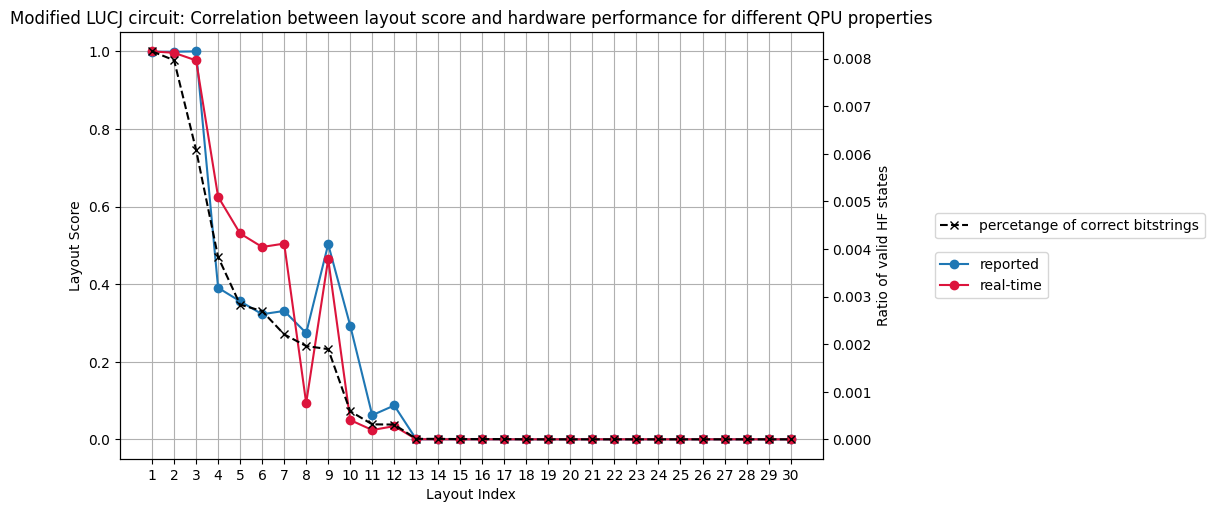

In [49]:
# Function to normalize an array using Min-Max Scaling
def normalize(x):
    x = np.asarray(x)
    return (x - np.min(x)) / (np.max(x) - np.min(x))


# Get costs data
x = np.asarray(scores.index.to_list()) + 1
r = scores.ratio
repo = scores.cost_reported
lf = scores.cost_lf

# Normaliza data
repo = normalize(repo)
lf = normalize(lf)

# Create the figure and primary y-axis
fig, ax1 = plt.subplots(figsize=(12, 5))

# Create the secondary y-axis
ax2 = ax1.twinx()

# Plot the data
ax1.plot(x, repo, marker="o", linestyle="-", label="reported")
ax1.plot(x, lf, marker="o", linestyle="-", label="real-time", color="crimson")
ax2.plot(
    x,
    r,
    color="black",
    marker="x",
    linestyle="--",
    label="percetange of correct bitstrings",
)

# Set labels and titles
ax1.set_xlabel("Layout Index")
ax1.set_xticks(x)
ax1.set_ylabel("Layout Score")
ax2.set_ylabel("Ratio of valid HF states")
ax1.legend(loc="upper left", bbox_to_anchor=(1.15, 0.5))
ax2.legend(loc="lower left", bbox_to_anchor=(1.15, 0.5))
ax1.grid()
plt.xlabel("Layout number")
fig.tight_layout()
plt.title(
    "Modified LUCJ circuit: Correlation between layout score and hardware performance for different QPU properties"
)

However, in some situations, real-time characterization can provide a clear advantage. For example, if a qubit is strongly interacting with a two-level system (TLS) during the experiment—but such intercation was not there when the last reported fidelity was uploaded—then the real-time QPU properties will capture this change, while the reported properties will not.

Another motivation for running characterization experiments before executing a circuit is to overwrite unrealistic error values. In Qiskit, some gate errors may be reported as 1 when randomized benchmarking fits fail. Although these values do not reflect the true performance of the gate, they can skew predictions. Characterization experiments can replace such placeholder values with updated estimates, providing a more realistic description of the hardware. More details about this behavior are discussed in the Appendix section.

### Key Takeaways

We found a clear correlation between QPU error properties and hardware performance across different qubit layouts. A scoring function can be used to estimate circuit fidelity on specific device regions and predict which layouts will perform best—either through Qiskit’s built-in transpile function or a custom implementation.

Because these scoring functions rely on QPU error properties, having accurate and up-to-date data is essential. Qiskit generally provides reliable, recent property information, which is often sufficient for identifying promising layouts. However, for higher accuracy, it is recommended to run real-time characterization experiments as close in time as possible to the execution of the circuit of interest.

Real-time characterization helps capture fast hardware dynamics, such as fluctuations from two-level system (TLS) interactions, and can also overwrite inaccurate error values resulting from failed randomized benchmarking fits.

If you can allocate additional QPU time for these experiments, doing so is highly recommended—it can significantly improve circuit reliability and overall performance.

## Appendix

In this section, we examine the specific case where single-qubit or two-qubit gate errors are reported as having a value of `1` in Qiskit. An error value of `1` corresponds to a gate fidelity of `1 – error = 0`.

These values typically arise when randomized benchmarking (RB) fits fail for poorly performing gates. In such cases, the default error is set to `1`. While the true error is likely close to `1`, using this default value can lead to underestimating the actual hardware performance, depending on how the scoring function evaluates layouts during transpilation.

For example, if all two-qubit errors (such as `cz` or `rzz`) for a specific gate, say `(0, 1)`, are reported with an error of `1`, then the average two-qubit error for that edge is `1`, which corresponds to a fidelity of `0`. In the scoring function implemented in this tutorial, the total circuit fidelity is multiplied by this value, which forces the entire product to `0`. As a result, the layout is automatically ruled out as extremely poor-performing, even though other gates in the same layout may still function well.

To illustrate this, take a look at the example below that extracts layouts with single- or two-qubit errors equal to `1`.

In [40]:
valid_layouts = []
invalid_layouts = []
invalid_edges = []
invalid_qubits = []
for i, layout in enumerate(all_layouts):
    errors = []
    edges = get_edges(layout, backend)
    for edge in edges:
        error = backend.properties().gate_error(twoq_gate, edge)
        errors.append(error)
        if error == 1:
            invalid_edges.append(edge) if edge not in invalid_edges else None
    for qubit in layout:
        error = backend.properties().gate_error("sx", qubit)
        errors.append(error)
        if error == 1:
            invalid_qubits.append(
                qubit
            ) if qubit not in invalid_qubits else None
    if all(err < 1 for err in errors):
        valid_layouts.append(layout)
    else:
        invalid_layouts.append(layout)

print("Number of valid layouts (all errors < 1):", len(valid_layouts))
print(
    "Number of invalid layouts (one or more errors == 1):",
    len(invalid_layouts),
)
print("List of invalid 1Q gates:", invalid_qubits)
print("List of invalid 2Q gates:", invalid_edges)
if invalid_qubits:
    print("Quick example:")
    print(
        f"1Q error for {invalid_qubits[0]}:",
        backend.properties().gate_error("sx", invalid_qubits[0]),
    )
if invalid_edges:
    print(
        f"2Q error for {invalid_edges[0]}:",
        backend.properties().gate_error(twoq_gate, invalid_edges[0]),
    )

Number of valid layouts (all errors < 1): 158
Number of invalid layouts (one or more errors == 1): 48
List of invalid 1Q gates: [72]
List of invalid 2Q gates: [(27, 28), (71, 72), (33, 32), (28, 27), (32, 33), (72, 71)]
Quick example:
1Q error for 72: 1
2Q error for (27, 28): 1


The reported QPU error values are directly used during the transpilation step, where gate error properties guide the selection of the predicted highest-performing layouts for a quantum circuit.

When a layout includes one or more gates with a reported error value of `1`, the effect on scoring can be severe. In some cases, this can force an entire layout score to `0`, even if other gates in the layout perform reasonably well. By contrast, when using real-time QPU properties, the same layout often receives a nonzero score, reflecting a more realistic estimate of its true performance.

In [41]:
if invalid_layouts:
    pass_manager_invalid = generate_preset_pass_manager(
        optimization_level=3,
        backend=backend,
        initial_layout=invalid_layouts[8],
        seed_transpiler=42,
    )

    # Set the pre-initialization stage of the pass manager with passes suggested by ffsim
    pass_manager_invalid.pre_init = ffsim.qiskit.PRE_INIT
    pass_manager_invalid.post_init = PassManager([RemoveIdentityEquivalent()])
    pass_manager_invalid.post_optimization = PassManager(
        [FoldRzzAngle(), RemoveIdentityEquivalent(target=backend.target)]
    )
    transpiled_invalid = pass_manager_invalid.run(circuit)

    print(
        "Score from reported QPU properties:",
        qiskit_cost(backend, transpiled_invalid),
    )
    print(
        "Score from real-time QPU properties:",
        qiskit_cost(backend_updated, transpiled_invalid),
    )

Score from reported QPU properties: 0.0
Score from real-time QPU properties: 3.170245705431666e-17


This following case was observed on the backend `ibm_fez` at a past time. In this example, all layouts had one or more gates with reported errors equal to `1`. This occurs when benchmarking fits fail and the error is defaulted to the maximum value. In this case, the real-time properties were much better at predicting actual hardware performance, which provides a strong reason for running characterization experiments.

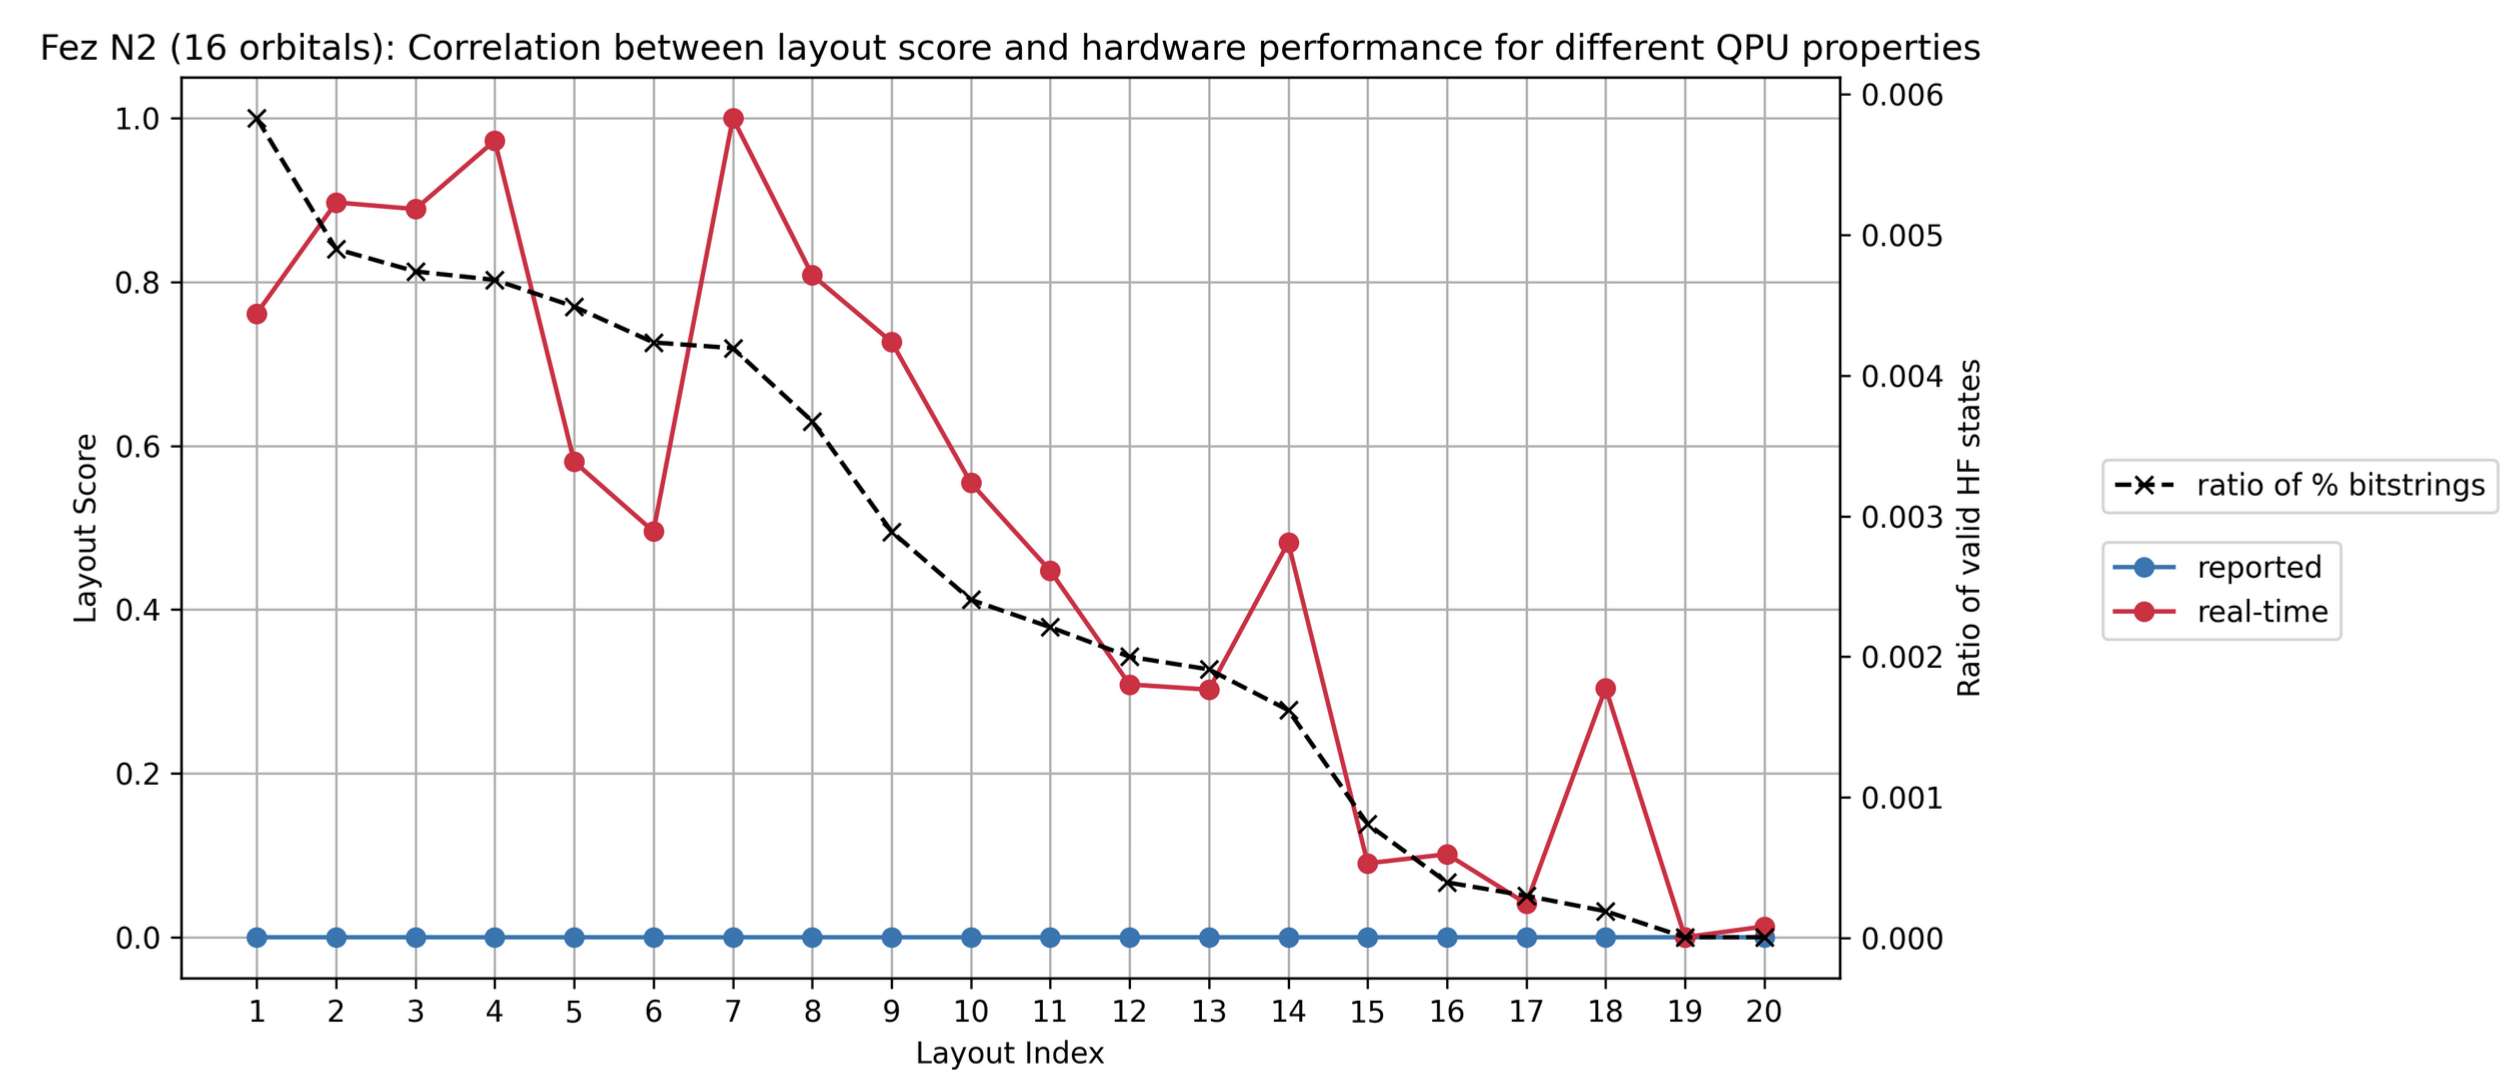